### CASE 1 Visualize the Experiment Result

In [1]:
from cornac.experiment.experiment_explainers import Experiment_Explainers
from cornac.datasets.goodreads import prepare_data
from cornac.datasets import goodreads
from cornac.metrics_explainer import (
    Metric_Exp_DIV as DIV,
    Metric_Exp_FPR as FPR,
    Metric_Exp_FA as FA,
    Metric_Exp_RA as RA,
)
from cornac.models import EFM, MTER
from cornac.models import ALS, MF, EMF, NEMF

from cornac.explainer import Exp_EFM, Exp_MTER
from cornac.explainer import (
    Exp_ALS as ALSExplainer,
    Exp_PHI4MF as PHI4MFExplainer,
    Exp_SU4EMF as EMFExplainer,
)

from cornac.experiment import Visualization
from cornac.utils import cache
import warnings

warnings.filterwarnings("ignore")

/Users/yaoyao/miniconda3/envs/rose/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/yaoyao/miniconda3/envs/rose/lib/python3.9/site-packages/flatbuffers/compat.py:19: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp


In [3]:
rs_sent_dense = prepare_data(
    data_name="goodreads",
    test_size=0,
    dense=True,
    item=True,
    user=True,
    sample_size=1,
    seed=21,
)
fdiv = DIV()
fpr = FPR()
ground_truth_good_reads = goodreads.load_sentiment()
fpr_with_input_as_groundtruth = FPR(ground_truth=ground_truth_good_reads)
efm = EFM(
    max_iter=20,
    num_explicit_factors=50,
    num_latent_factors=50,
    num_most_cared_aspects=50,
    alpha=0.85,
    lambda_h=0.1,
    lambda_u=0.001,
    lambda_v=0.01,
    lambda_x=1.0,
    lambda_y=0.1,
)
efm_exp = Exp_EFM(rec_model=efm, dataset=rs_sent_dense.train_set)
mter = MTER(
    max_iter=20,
    n_aspect_factors=8,
    n_item_factors=5,
    n_opinion_factors=5,
    n_user_factors=10,
    lambda_bpr=10,
    lambda_reg=10,
    n_bpr_samples=1000,
    n_element_samples=50,
)
mter_exp = Exp_MTER(rec_model=mter, dataset=rs_sent_dense.train_set)

rs_dense = prepare_data(
    data_name="goodreads_uir_1000",
    test_size=0,
    dense=True,
    item=True,
    user=True,
    sample_size=1,
    seed=21,
)
emf = EMF(
    k=10,
    max_iter=500,
    learning_rate=0.001,
    lambda_reg=0.1,
    explain_reg=0.01,
    verbose=True,
    seed=6,
    num_threads=6,
    early_stop=True,
)
nemf = NEMF(
    k=10,
    max_iter=500,
    learning_rate=0.001,
    lambda_reg=0.1,
    explain_reg=0.01,
    novel_reg=1,
    verbose=True,
    seed=6,
    num_threads=6,
    early_stop=True,
)
als = ALS(k=10, max_iter=500, lambda_reg=0.001, alpha=1, verbose=True, seed=6)
als_exp = ALSExplainer(rec_model=als, dataset=rs_dense.train_set)
emf_exp = EMFExplainer(rec_model=emf, dataset=rs_dense.train_set)
nemf_exp = EMFExplainer(rec_model=nemf, dataset=rs_dense.train_set)

# models = [(als, als_exp), (emf, emf_exp), (nemf, nemf_exp)]
models = [(als, als_exp)]
metrics = [fdiv]
experiment = Experiment_Explainers(
    eval_method=rs_dense,
    models=models,
    metrics=metrics,
    rec_k=10,
    feature_k=10,
    eval_train=True,
)
experiment.run()

models = [(efm, efm_exp), (mter, mter_exp)]
metrics = [fdiv, fpr_with_input_as_groundtruth]
experiment_sent = Experiment_Explainers(
    eval_method=rs_sent_dense,
    models=models,
    metrics=metrics,
    rec_k=10,
    feature_k=10,
    eval_train=True,
)
experiment_sent.run()

INFO:cornac.experiment.experiment_explainers:Start training Recommender ALS...
100%|██████████| 500/500 [00:01<00:00, 417.70it/s, loss=0.0285]
INFO:implicit:Final training loss 0.0285
INFO:cornac.experiment.experiment_explainers:*****Start evaluating model-explainer: 'ALS:Exp_ALS'...
INFO:cornac.experiment.experiment_explainers:Step 1/3: Recommender ALS creates recommendations
INFO:cornac.experiment.experiment_explainers:Step 2/3: Explainer Exp_ALS create explanation for all recommendations
Computing explanations: 100%|██████████| 1000/1000 [00:02<00:00, 335.76it/s]
INFO:cornac.experiment.experiment_explainers:Step 3/3: Metric Metric_Exp_DIV starts evaluation...
INFO:cornac.experiment.experiment_explainers:Result: Feature diversity: 0.15033573573555856
INFO:cornac.experiment.experiment_explainers:experiment data: [[0.15033573573555856, 1.234774112701416, 3.8778128623962402]]
INFO:cornac.experiment.experiment_explainers:Experiment result: 
 recommender:explainer |      Metric_Exp_DIV | 

Plot the bar chart for the metrics:


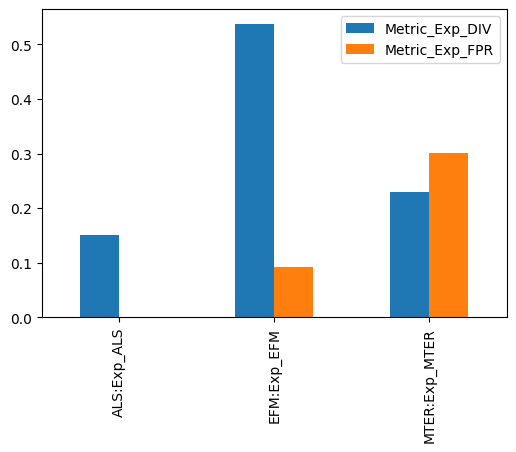

               Metric_Exp_DIV  Metric_Exp_FPR
ALS:Exp_ALS          0.150336        0.000000
EFM:Exp_EFM          0.537337        0.092513
MTER:Exp_MTER        0.229126        0.301079
Plot the bar chart for the cost:


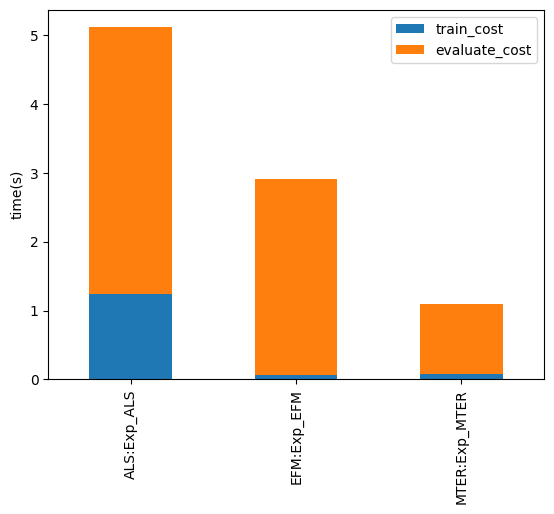

In [4]:
vis = Visualization()
vis.visualize_experiemnt_result([experiment, experiment_sent], kind="bar")

### CASE 2 Visualize the Effect of Parameters' Change (rec_k, feature_k)
Problem:
    - Explainaer_Experiment(models = [model_1, model_2], rec_k=10, feature_k = 10) fixed parameter for all models/explainers 
Solution:
    - Pass a list of Explainer_Experiment Object to func Visualization_Parameter_Change([EE_1, EE_2, EE_3], param_name = 'rec_k/feature_k')

##### 2.1 Metrics FDIV&FPR on the sentiment-related model & explainers vs feature_k

In [2]:
from cornac.experiment.experiment_explainers import Experiment_Explainers
from cornac.datasets.goodreads import prepare_data
from cornac.metrics_explainer import (
    Metric_Exp_DIV as DIV,
    Metric_Exp_FPR as FPR,
    Metric_Exp_FA as FA,
    Metric_Exp_RA as RA,
)
from cornac.models import EFM, MTER
from cornac.models import ALS, MF, EMF, NEMF

from cornac.explainer import Exp_EFM, Exp_MTER
from cornac.explainer import Exp_ALS, Exp_PHI4MF, Exp_SU4EMF

from cornac.experiment import Visualization
from cornac.utils import cache
import warnings

warnings.filterwarnings("ignore")

In [6]:
feature_k_list = [i for i in range(5, 11)]
rs_sent_dense = prepare_data(
    data_name="goodreads",
    test_size=0,
    dense=True,
    item=True,
    user=True,
    sample_size=1,
    seed=21,
)
fdiv = DIV()
fpr = FPR()
ground_truth_good_reads = goodreads.load_sentiment()
fpr_with_input_as_groundtruth = FPR(ground_truth=ground_truth_good_reads)
efm = EFM(
    max_iter=20,
    num_explicit_factors=50,
    num_latent_factors=50,
    num_most_cared_aspects=50,
    alpha=0.85,
    lambda_h=0.1,
    lambda_u=0.001,
    lambda_v=0.01,
    lambda_x=1.0,
    lambda_y=0.1,
)
efm_exp = Exp_EFM(rec_model=efm, dataset=rs_sent_dense.train_set)

mter = MTER(
    max_iter=20,
    n_aspect_factors=8,
    n_item_factors=5,
    n_opinion_factors=5,
    n_user_factors=10,
    lambda_bpr=10,
    lambda_reg=10,
    n_bpr_samples=1000,
    n_element_samples=50,
)
mter_exp = Exp_MTER(rec_model=mter, dataset=rs_sent_dense.train_set)

models = [(efm, efm_exp), (mter, mter_exp)]
metrics = [fdiv, fpr_with_input_as_groundtruth]

### To visualize the effect of increasing the number of features, we can run the experiment for different values of feature_k
EE_list = []
for feature_k in feature_k_list:
    experiment_sent = Experiment_Explainers(
        eval_method=rs_sent_dense,
        models=models,
        metrics=metrics,
        rec_k=10,
        feature_k=feature_k,
        eval_train=True,
    )
    experiment_sent.run()
    EE_list.append(experiment_sent)

INFO:cornac.experiment.experiment_explainers:Start training Recommender EFM...
INFO:cornac.experiment.experiment_explainers:*****Start evaluating model-explainer: 'EFM:Exp_EFM'...
INFO:cornac.experiment.experiment_explainers:Step 1/3: Recommender EFM creates recommendations
INFO:cornac.experiment.experiment_explainers:Step 2/3: Explainer Exp_EFM create explanation for all recommendations
Computing explanations: 100%|██████████| 1000/1000 [00:00<00:00, 8347.94it/s]
INFO:cornac.experiment.experiment_explainers:Step 3/3: Metric Metric_Exp_DIV starts evaluation...
INFO:cornac.experiment.experiment_explainers:Result: Feature diversity: 0.5531531531529946
INFO:cornac.experiment.experiment_explainers:Step 3/3: Metric Metric_Exp_FPR starts evaluation...
Start evaluation... :   0%|          | 0/9000 [00:00<?, ?it/s]
INFO:cornac.experiment.experiment_explainers:Result: Feature Precision: 0.3889541715628672; Feature Recall: 0.058709994930925845; Harmonic Mean: 0.09340723655307186
INFO:cornac.expe

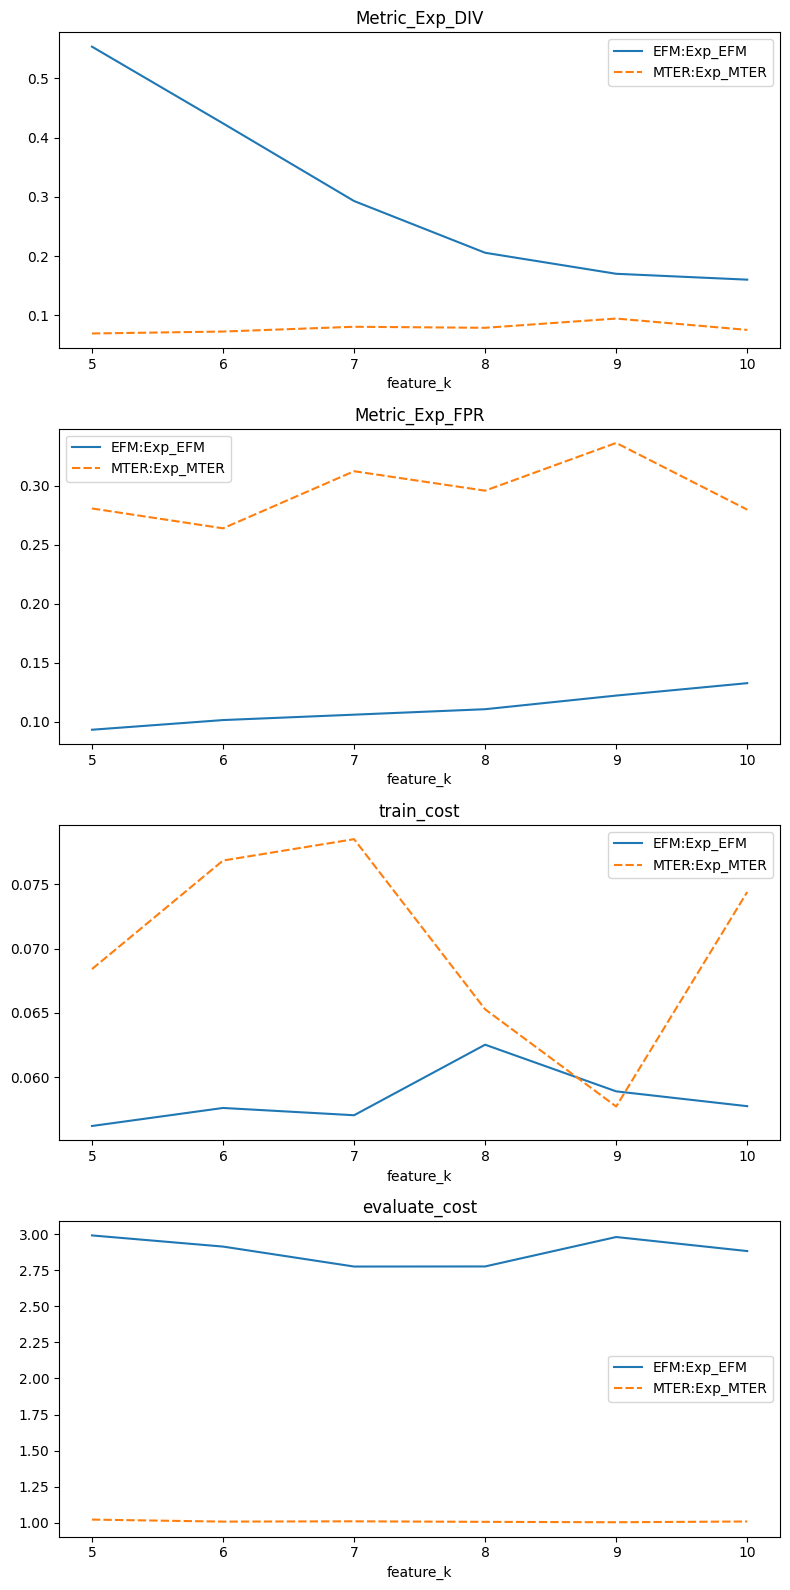

In [7]:
vis = Visualization()
vis.visualize_target_k(EE_list, target_k_name="feature_k", kind="line")

##### 2.1 Metrics FDIV on the MF models & explainers vs feature_k

In [3]:
rs_dense = prepare_data(
    data_name="goodreads_uir_1000",
    test_size=0,
    dense=True,
    item=True,
    user=True,
    sample_size=1,
    seed=21,
)
emf = EMF(
    k=10,
    max_iter=500,
    learning_rate=0.001,
    lambda_reg=0.1,
    explain_reg=0.01,
    verbose=True,
    seed=6,
    num_threads=6,
    early_stop=True,
)
nemf = NEMF(
    k=10,
    max_iter=500,
    learning_rate=0.001,
    lambda_reg=0.1,
    explain_reg=0.01,
    novel_reg=1,
    verbose=True,
    seed=6,
    num_threads=6,
    early_stop=True,
)
als = ALS(k=10, max_iter=500, lambda_reg=0.001, alpha=1, verbose=True, seed=6)
als_exp = Exp_ALS(rec_model=als, dataset=rs_dense.train_set)
emf_exp = Exp_PHI4MF(rec_model=emf, dataset=rs_dense.train_set)
nemf_exp = Exp_SU4EMF(rec_model=nemf, dataset=rs_dense.train_set)
fdiv = DIV()
models = [(als, als_exp), (emf, emf_exp), (nemf, nemf_exp)]
metrics = [fdiv]
experiment = Experiment_Explainers(
    eval_method=rs_dense,
    models=models,
    metrics=metrics,
    rec_k=10,
    feature_k=10,
    eval_train=True,
)

# feature_k_list = [i for i in range(5, 11)]
rec_k_list = [i for i in range(5, 11)]
EE_list = []
for rec_k in rec_k_list:
    print(f"\nCurrent loop: Processing rec_k = {rec_k}")
    experiment = Experiment_Explainers(
        eval_method=rs_dense,
        models=models,
        metrics=metrics,
        rec_k=rec_k,
        feature_k=10,
        eval_train=True,
    )
    experiment.run()
    EE_list.append(experiment)

INFO:cornac.experiment.experiment_explainers:Start training Recommender ALS...



Current loop: Processing rec_k = 5


100%|██████████| 500/500 [00:00<00:00, 514.58it/s, loss=0.0284]
INFO:implicit:Final training loss 0.0284
INFO:cornac.experiment.experiment_explainers:*****Start evaluating model-explainer: 'ALS:Exp_ALS'...
INFO:cornac.experiment.experiment_explainers:Step 1/3: Recommender ALS creates recommendations
INFO:cornac.experiment.experiment_explainers:Step 2/3: Explainer Exp_ALS create explanation for all recommendations
Computing explanations: 100%|██████████| 500/500 [00:01<00:00, 348.22it/s]
INFO:cornac.experiment.experiment_explainers:Step 3/3: Metric Metric_Exp_DIV starts evaluation...
INFO:cornac.experiment.experiment_explainers:Result: Feature diversity: 0.16224448897796936
INFO:cornac.experiment.experiment_explainers:Start training Recommender EMF...
100%|██████████| 500/500 [00:00<00:00, 2199.36it/s, loss=6035.53]
INFO:cornac.experiment.experiment_explainers:*****Start evaluating model-explainer: 'EMF:Exp_PHI4MF'...
INFO:cornac.experiment.experiment_explainers:Step 1/3: Recommender EM

Optimization finished!


Computing explanations:   3%|▎         | 16/500 [00:51<18:32,  2.30s/it] 

Association rules generated


Computing explanations: 100%|██████████| 500/500 [00:53<00:00,  9.29it/s] 
INFO:cornac.experiment.experiment_explainers:Step 3/3: Metric Metric_Exp_DIV starts evaluation...
INFO:cornac.experiment.experiment_explainers:Result: Feature diversity: 0.0004985971943887793


========================{'[18693716, 25251757, 11861062, 8356487]': 1.0, '[21853633, 25251757, 18693716, 304027, 676924]': 1.0, '[12812550, 8559047, 17801656, 304027, 2248573]': 1.0, '[12812550, 8559047, 18693716, 304027, 2248573]': 1.0, '[12812550, 8559047, 304027, 2248573, 22431039]': 1.0, '[8559047, 16151178, 17801656, 304027, 2248573]': 1.0, '[8559047, 16151178, 18693716, 304027, 2248573]': 1.0, '[8559047, 16151178, 304027, 2248573, 22431039]': 1.0, '[8559047, 18693716, 17801656, 304027, 2248573]': 1.0, '[8559047, 17801656, 304027, 2248573, 22431039]': 1.0}========================


INFO:cornac.experiment.experiment_explainers:Start training Recommender NEMF...


Start compute edge weight matrix...
Start compute novel matrix...
Matrix computation finished!


100%|██████████| 500/500 [00:00<00:00, 2048.52it/s, loss=6222.49]
INFO:cornac.experiment.experiment_explainers:*****Start evaluating model-explainer: 'NEMF:Exp_SU4EMF'...
INFO:cornac.experiment.experiment_explainers:Step 1/3: Recommender NEMF creates recommendations
INFO:cornac.experiment.experiment_explainers:Step 2/3: Explainer Exp_SU4EMF create explanation for all recommendations


Optimization finished!


Computing explanations: 100%|██████████| 500/500 [00:00<00:00, 1477.36it/s]
INFO:cornac.experiment.experiment_explainers:Step 3/3: Metric Metric_Exp_DIV starts evaluation...
INFO:cornac.experiment.experiment_explainers:Result: Feature diversity: 0.3912677100233456
INFO:cornac.experiment.experiment_explainers:experiment data: [[0.16224448897796936, 1.009835958480835, 1.8046019077301025], [0.0004985971943887793, 0.26682400703430176, 54.07922410964966], [0.3912677100233456, 0.3021371364593506, 0.5608870983123779]]
INFO:cornac.experiment.experiment_explainers:Experiment result: 
 recommender:explainer |        Metric_Exp_DIV |            Train(s) |        Evaluate(s)
ALS:Exp_ALS           |   0.16224448897796936 |   1.009835958480835 | 1.8046019077301025
EMF:Exp_PHI4MF        | 0.0004985971943887793 | 0.26682400703430176 |  54.07922410964966
NEMF:Exp_SU4EMF       |    0.3912677100233456 |  0.3021371364593506 | 0.5608870983123779

INFO:cornac.experiment.experiment_explainers:Start training 


Current loop: Processing rec_k = 6


100%|██████████| 500/500 [00:00<00:00, 659.66it/s, loss=0.0284]
INFO:implicit:Final training loss 0.0284
INFO:cornac.experiment.experiment_explainers:*****Start evaluating model-explainer: 'ALS:Exp_ALS'...
INFO:cornac.experiment.experiment_explainers:Step 1/3: Recommender ALS creates recommendations
INFO:cornac.experiment.experiment_explainers:Step 2/3: Explainer Exp_ALS create explanation for all recommendations
Computing explanations: 100%|██████████| 600/600 [00:01<00:00, 307.66it/s]
INFO:cornac.experiment.experiment_explainers:Step 3/3: Metric Metric_Exp_DIV starts evaluation...
INFO:cornac.experiment.experiment_explainers:Result: Feature diversity: 0.16046188091255215
INFO:cornac.experiment.experiment_explainers:Start training Recommender EMF...
100%|██████████| 500/500 [00:00<00:00, 2427.05it/s, loss=5976.13]
INFO:cornac.experiment.experiment_explainers:*****Start evaluating model-explainer: 'EMF:Exp_PHI4MF'...
INFO:cornac.experiment.experiment_explainers:Step 1/3: Recommender EM

Optimization finished!


Computing explanations: 100%|██████████| 600/600 [00:02<00:00, 228.26it/s]
INFO:cornac.experiment.experiment_explainers:Step 3/3: Metric Metric_Exp_DIV starts evaluation...
INFO:cornac.experiment.experiment_explainers:Result: Feature diversity: 0.0005837506956037812


========================{'[5161066, 6366437, 12127750, 12812550]': 1.0, '[5161066, 140075, 16151178, 5060378, 18816603]': 1.0, '[8356487, 5161066, 140075, 13623150, 5060378]': 1.0, '[8356487, 5161066, 140075, 5060378, 18816603]': 1.0, '[12127750, 5161066, 140075, 13623150, 5060378]': 1.0, '[12127750, 5161066, 140075, 5060378, 18816603]': 1.0, '[13486632, 5161066, 140075, 18293427, 5060378]': 1.0, '[13486632, 5161066, 140075, 5060378, 18816603]': 1.0, '[16151178, 140075, 5161066, 13623150, 5060378]': 1.0, '[5161066, 140075, 13623150, 5060378, 18816603]': 1.0}========================


INFO:cornac.experiment.experiment_explainers:Start training Recommender NEMF...


Start compute edge weight matrix...
Start compute novel matrix...
Matrix computation finished!


100%|██████████| 500/500 [00:00<00:00, 2645.28it/s, loss=6309.88]
INFO:cornac.experiment.experiment_explainers:*****Start evaluating model-explainer: 'NEMF:Exp_SU4EMF'...
INFO:cornac.experiment.experiment_explainers:Step 1/3: Recommender NEMF creates recommendations
INFO:cornac.experiment.experiment_explainers:Step 2/3: Explainer Exp_SU4EMF create explanation for all recommendations


Optimization finished!


Computing explanations: 100%|██████████| 600/600 [00:00<00:00, 1409.33it/s]
INFO:cornac.experiment.experiment_explainers:Step 3/3: Metric Metric_Exp_DIV starts evaluation...
INFO:cornac.experiment.experiment_explainers:Result: Feature diversity: 0.3909548740847672
INFO:cornac.experiment.experiment_explainers:experiment data: [[0.16046188091255215, 0.7600250244140625, 2.365712881088257], [0.0005837506956037812, 0.24428009986877441, 2.932135820388794], [0.3909548740847672, 0.2402350902557373, 0.728348970413208]]
INFO:cornac.experiment.experiment_explainers:Experiment result: 
 recommender:explainer |        Metric_Exp_DIV |            Train(s) |       Evaluate(s)
ALS:Exp_ALS           |   0.16046188091255215 |  0.7600250244140625 | 2.365712881088257
EMF:Exp_PHI4MF        | 0.0005837506956037812 | 0.24428009986877441 | 2.932135820388794
NEMF:Exp_SU4EMF       |    0.3909548740847672 |  0.2402350902557373 | 0.728348970413208

INFO:cornac.experiment.experiment_explainers:Start training Recom


Current loop: Processing rec_k = 7


100%|██████████| 500/500 [00:00<00:00, 688.27it/s, loss=0.0284]
INFO:implicit:Final training loss 0.0284
INFO:cornac.experiment.experiment_explainers:*****Start evaluating model-explainer: 'ALS:Exp_ALS'...
INFO:cornac.experiment.experiment_explainers:Step 1/3: Recommender ALS creates recommendations
INFO:cornac.experiment.experiment_explainers:Step 2/3: Explainer Exp_ALS create explanation for all recommendations
Computing explanations: 100%|██████████| 700/700 [00:02<00:00, 262.64it/s]
INFO:cornac.experiment.experiment_explainers:Step 3/3: Metric Metric_Exp_DIV starts evaluation...
INFO:cornac.experiment.experiment_explainers:Result: Feature diversity: 0.15914980584490004
INFO:cornac.experiment.experiment_explainers:Start training Recommender EMF...
100%|██████████| 500/500 [00:00<00:00, 3064.66it/s, loss=5989.47]
INFO:cornac.experiment.experiment_explainers:*****Start evaluating model-explainer: 'EMF:Exp_PHI4MF'...
INFO:cornac.experiment.experiment_explainers:Step 1/3: Recommender EM

Optimization finished!


Computing explanations: 100%|██████████| 700/700 [00:03<00:00, 231.13it/s]
INFO:cornac.experiment.experiment_explainers:Step 3/3: Metric Metric_Exp_DIV starts evaluation...
INFO:cornac.experiment.experiment_explainers:Result: Feature diversity: 0.0005575311669732224


========================{'[18693716, 25251757, 11861062, 12127750]': 1.0, '[27071490, 6437061, 25251757, 21965107, 2168860]': 1.0, '[27071490, 7686667, 25251757, 21965107, 2168860]': 1.0, '[11861062, 8559047, 8537327, 13312527, 2168860]': 1.0, '[11861062, 8559047, 8537327, 21965107, 2168860]': 1.0, '[11861062, 8559047, 8537327, 2168860, 22431039]': 1.0, '[11861062, 8559047, 25251757, 8537327, 2168860]': 1.0, '[8559047, 8537327, 13312527, 21965107, 2168860]': 1.0, '[8559047, 8537327, 13312527, 2168860, 22431039]': 1.0, '[8559047, 25251757, 8537327, 13312527, 2168860]': 1.0}========================


INFO:cornac.experiment.experiment_explainers:Start training Recommender NEMF...


Start compute edge weight matrix...
Start compute novel matrix...
Matrix computation finished!


100%|██████████| 500/500 [00:00<00:00, 2055.07it/s, loss=6320.33]
INFO:cornac.experiment.experiment_explainers:*****Start evaluating model-explainer: 'NEMF:Exp_SU4EMF'...
INFO:cornac.experiment.experiment_explainers:Step 1/3: Recommender NEMF creates recommendations
INFO:cornac.experiment.experiment_explainers:Step 2/3: Explainer Exp_SU4EMF create explanation for all recommendations


Optimization finished!


Computing explanations: 100%|██████████| 700/700 [00:00<00:00, 1365.61it/s]
INFO:cornac.experiment.experiment_explainers:Step 3/3: Metric Metric_Exp_DIV starts evaluation...
INFO:cornac.experiment.experiment_explainers:Result: Feature diversity: 0.3912824394418823
INFO:cornac.experiment.experiment_explainers:experiment data: [[0.15914980584490004, 0.7286179065704346, 3.190131902694702], [0.0005575311669732224, 0.20107197761535645, 3.4181790351867676], [0.3912824394418823, 0.2936975955963135, 0.918175220489502]]
INFO:cornac.experiment.experiment_explainers:Experiment result: 
 recommender:explainer |        Metric_Exp_DIV |            Train(s) |        Evaluate(s)
ALS:Exp_ALS           |   0.15914980584490004 |  0.7286179065704346 |  3.190131902694702
EMF:Exp_PHI4MF        | 0.0005575311669732224 | 0.20107197761535645 | 3.4181790351867676
NEMF:Exp_SU4EMF       |    0.3912824394418823 |  0.2936975955963135 |  0.918175220489502

INFO:cornac.experiment.experiment_explainers:Start training 


Current loop: Processing rec_k = 8


100%|██████████| 500/500 [00:00<00:00, 509.28it/s, loss=0.0284]
INFO:implicit:Final training loss 0.0284
INFO:cornac.experiment.experiment_explainers:*****Start evaluating model-explainer: 'ALS:Exp_ALS'...
INFO:cornac.experiment.experiment_explainers:Step 1/3: Recommender ALS creates recommendations
INFO:cornac.experiment.experiment_explainers:Step 2/3: Explainer Exp_ALS create explanation for all recommendations
Computing explanations: 100%|██████████| 800/800 [00:02<00:00, 359.53it/s]
INFO:cornac.experiment.experiment_explainers:Step 3/3: Metric Metric_Exp_DIV starts evaluation...
INFO:cornac.experiment.experiment_explainers:Result: Feature diversity: 0.15556070087582885
INFO:cornac.experiment.experiment_explainers:Start training Recommender EMF...
100%|██████████| 500/500 [00:00<00:00, 2235.29it/s, loss=6026.83]
INFO:cornac.experiment.experiment_explainers:*****Start evaluating model-explainer: 'EMF:Exp_PHI4MF'...
INFO:cornac.experiment.experiment_explainers:Step 1/3: Recommender EM

Optimization finished!


Computing explanations: 100%|██████████| 800/800 [00:03<00:00, 218.23it/s]
INFO:cornac.experiment.experiment_explainers:Step 3/3: Metric Metric_Exp_DIV starts evaluation...
INFO:cornac.experiment.experiment_explainers:Result: Feature diversity: 0.0005290988735919831


========================{'[18693716, 25251757, 11861062, 8356487]': 1.0, '[21853633, 25251757, 18693716, 304027, 676924]': 1.0, '[12812550, 8559047, 17801656, 304027, 2248573]': 1.0, '[12812550, 8559047, 18693716, 304027, 2248573]': 1.0, '[12812550, 8559047, 304027, 2248573, 22431039]': 1.0, '[8559047, 16151178, 17801656, 304027, 2248573]': 1.0, '[8559047, 16151178, 18693716, 304027, 2248573]': 1.0, '[8559047, 16151178, 304027, 2248573, 22431039]': 1.0, '[8559047, 18693716, 17801656, 304027, 2248573]': 1.0, '[8559047, 17801656, 304027, 2248573, 22431039]': 1.0}========================


INFO:cornac.experiment.experiment_explainers:Start training Recommender NEMF...


Start compute edge weight matrix...
Start compute novel matrix...
Matrix computation finished!


100%|██████████| 500/500 [00:00<00:00, 2008.22it/s, loss=6321.54]
INFO:cornac.experiment.experiment_explainers:*****Start evaluating model-explainer: 'NEMF:Exp_SU4EMF'...
INFO:cornac.experiment.experiment_explainers:Step 1/3: Recommender NEMF creates recommendations
INFO:cornac.experiment.experiment_explainers:Step 2/3: Explainer Exp_SU4EMF create explanation for all recommendations


Optimization finished!


Computing explanations: 100%|██████████| 800/800 [00:00<00:00, 1367.69it/s]
INFO:cornac.experiment.experiment_explainers:Step 3/3: Metric Metric_Exp_DIV starts evaluation...
INFO:cornac.experiment.experiment_explainers:Result: Feature diversity: 0.38923644262618207
INFO:cornac.experiment.experiment_explainers:experiment data: [[0.15556070087582885, 0.9842381477355957, 2.893815755844116], [0.0005290988735919831, 0.26506805419921875, 4.159044981002808], [0.38923644262618207, 0.2997760772705078, 1.124837875366211]]
INFO:cornac.experiment.experiment_explainers:Experiment result: 
 recommender:explainer |        Metric_Exp_DIV |            Train(s) |       Evaluate(s)
ALS:Exp_ALS           |   0.15556070087582885 |  0.9842381477355957 | 2.893815755844116
EMF:Exp_PHI4MF        | 0.0005290988735919831 | 0.26506805419921875 | 4.159044981002808
NEMF:Exp_SU4EMF       |   0.38923644262618207 |  0.2997760772705078 | 1.124837875366211

INFO:cornac.experiment.experiment_explainers:Start training Rec


Current loop: Processing rec_k = 9


100%|██████████| 500/500 [00:00<00:00, 637.91it/s, loss=0.0284]
INFO:implicit:Final training loss 0.0284
INFO:cornac.experiment.experiment_explainers:*****Start evaluating model-explainer: 'ALS:Exp_ALS'...
INFO:cornac.experiment.experiment_explainers:Step 1/3: Recommender ALS creates recommendations
INFO:cornac.experiment.experiment_explainers:Step 2/3: Explainer Exp_ALS create explanation for all recommendations
Computing explanations: 100%|██████████| 900/900 [00:02<00:00, 361.39it/s]
INFO:cornac.experiment.experiment_explainers:Step 3/3: Metric Metric_Exp_DIV starts evaluation...
INFO:cornac.experiment.experiment_explainers:Result: Feature diversity: 0.15412062785778907
INFO:cornac.experiment.experiment_explainers:Start training Recommender EMF...
100%|██████████| 500/500 [00:00<00:00, 2354.95it/s, loss=5987.76]
INFO:cornac.experiment.experiment_explainers:*****Start evaluating model-explainer: 'EMF:Exp_PHI4MF'...
INFO:cornac.experiment.experiment_explainers:Step 1/3: Recommender EM

Optimization finished!


Computing explanations: 100%|██████████| 900/900 [00:03<00:00, 238.19it/s]
INFO:cornac.experiment.experiment_explainers:Step 3/3: Metric Metric_Exp_DIV starts evaluation...
INFO:cornac.experiment.experiment_explainers:Result: Feature diversity: 0.0005507353849956655


========================{'[18693716, 25251757, 11861062, 8356487]': 1.0, '[21853633, 25251757, 18693716, 304027, 676924]': 1.0, '[12812550, 8559047, 17801656, 304027, 2248573]': 1.0, '[12812550, 8559047, 18693716, 304027, 2248573]': 1.0, '[12812550, 8559047, 304027, 2248573, 22431039]': 1.0, '[8559047, 16151178, 17801656, 304027, 2248573]': 1.0, '[8559047, 16151178, 18693716, 304027, 2248573]': 1.0, '[8559047, 16151178, 304027, 2248573, 22431039]': 1.0, '[8559047, 18693716, 17801656, 304027, 2248573]': 1.0, '[8559047, 17801656, 304027, 2248573, 22431039]': 1.0}========================


INFO:cornac.experiment.experiment_explainers:Start training Recommender NEMF...


Start compute edge weight matrix...
Start compute novel matrix...
Matrix computation finished!


 19%|█▉        | 97/500 [00:00<00:00, 1076.77it/s, loss=6321.45]
INFO:cornac.experiment.experiment_explainers:*****Start evaluating model-explainer: 'NEMF:Exp_SU4EMF'...
INFO:cornac.experiment.experiment_explainers:Step 1/3: Recommender NEMF creates recommendations
INFO:cornac.experiment.experiment_explainers:Step 2/3: Explainer Exp_SU4EMF create explanation for all recommendations


Early stopping, delta_loss = 0.0000
Optimization finished!


Computing explanations: 100%|██████████| 900/900 [00:00<00:00, 1587.26it/s]
INFO:cornac.experiment.experiment_explainers:Step 3/3: Metric Metric_Exp_DIV starts evaluation...
INFO:cornac.experiment.experiment_explainers:Result: Feature diversity: 0.3891825955938426
INFO:cornac.experiment.experiment_explainers:experiment data: [[0.15412062785778907, 0.7856850624084473, 3.241725206375122], [0.0005507353849956655, 0.25014495849609375, 4.405704021453857], [0.3891825955938426, 0.14067721366882324, 1.1704628467559814]]
INFO:cornac.experiment.experiment_explainers:Experiment result: 
 recommender:explainer |        Metric_Exp_DIV |            Train(s) |        Evaluate(s)
ALS:Exp_ALS           |   0.15412062785778907 |  0.7856850624084473 |  3.241725206375122
EMF:Exp_PHI4MF        | 0.0005507353849956655 | 0.25014495849609375 |  4.405704021453857
NEMF:Exp_SU4EMF       |    0.3891825955938426 | 0.14067721366882324 | 1.1704628467559814

INFO:cornac.experiment.experiment_explainers:Start training


Current loop: Processing rec_k = 10


100%|██████████| 500/500 [00:00<00:00, 696.20it/s, loss=0.0284]
INFO:implicit:Final training loss 0.0284
INFO:cornac.experiment.experiment_explainers:*****Start evaluating model-explainer: 'ALS:Exp_ALS'...
INFO:cornac.experiment.experiment_explainers:Step 1/3: Recommender ALS creates recommendations
INFO:cornac.experiment.experiment_explainers:Step 2/3: Explainer Exp_ALS create explanation for all recommendations
Computing explanations: 100%|██████████| 1000/1000 [00:02<00:00, 339.94it/s]
INFO:cornac.experiment.experiment_explainers:Step 3/3: Metric Metric_Exp_DIV starts evaluation...
INFO:cornac.experiment.experiment_explainers:Result: Feature diversity: 0.152782982982854
INFO:cornac.experiment.experiment_explainers:Start training Recommender EMF...
100%|██████████| 500/500 [00:00<00:00, 2638.05it/s, loss=5992.53]
INFO:cornac.experiment.experiment_explainers:*****Start evaluating model-explainer: 'EMF:Exp_PHI4MF'...
INFO:cornac.experiment.experiment_explainers:Step 1/3: Recommender EM

Optimization finished!


Computing explanations: 100%|██████████| 1000/1000 [00:04<00:00, 235.75it/s]
INFO:cornac.experiment.experiment_explainers:Step 3/3: Metric Metric_Exp_DIV starts evaluation...
INFO:cornac.experiment.experiment_explainers:Result: Feature diversity: 0.0005787787787787744


========================{'[16068905, 27556157, 11861062, 8537327]': 1.0, '[118944, 21853633, 8559047, 13486632, 21953012]': 1.0, '[6609765, 8356487, 8559047, 140075, 27556157]': 1.0, '[6609765, 8356487, 8559047, 140075, 21953012]': 1.0, '[6609765, 8356487, 8559047, 140075, 18293427]': 1.0, '[140075, 18293427, 21953012, 27556157, 2213661]': 1.0, '[8559047, 140075, 21953012, 27556157, 2213661]': 1.0, '[8559047, 140075, 18293427, 27556157, 2213661]': 1.0, '[8559047, 140075, 18293427, 21953012, 2213661]': 1.0, '[8356487, 140075, 21953012, 27556157, 2213661]': 1.0}========================


INFO:cornac.experiment.experiment_explainers:Start training Recommender NEMF...


Start compute edge weight matrix...
Start compute novel matrix...
Matrix computation finished!


 10%|█         | 51/500 [00:00<00:00, 2210.97it/s, loss=6321.41]
INFO:cornac.experiment.experiment_explainers:*****Start evaluating model-explainer: 'NEMF:Exp_SU4EMF'...
INFO:cornac.experiment.experiment_explainers:Step 1/3: Recommender NEMF creates recommendations
INFO:cornac.experiment.experiment_explainers:Step 2/3: Explainer Exp_SU4EMF create explanation for all recommendations


Early stopping, delta_loss = 0.0000
Optimization finished!


Computing explanations: 100%|██████████| 1000/1000 [00:00<00:00, 1613.26it/s]
INFO:cornac.experiment.experiment_explainers:Step 3/3: Metric Metric_Exp_DIV starts evaluation...
INFO:cornac.experiment.experiment_explainers:Result: Feature diversity: 0.38852611659265485
INFO:cornac.experiment.experiment_explainers:experiment data: [[0.152782982982854, 0.7205359935760498, 3.8625118732452393], [0.0005787787787787744, 0.22730779647827148, 4.975583076477051], [0.38852611659265485, 0.07364296913146973, 1.350818157196045]]
INFO:cornac.experiment.experiment_explainers:Experiment result: 
 recommender:explainer |        Metric_Exp_DIV |            Train(s) |        Evaluate(s)
ALS:Exp_ALS           |     0.152782982982854 |  0.7205359935760498 | 3.8625118732452393
EMF:Exp_PHI4MF        | 0.0005787787787787744 | 0.22730779647827148 |  4.975583076477051
NEMF:Exp_SU4EMF       |   0.38852611659265485 | 0.07364296913146973 |  1.350818157196045



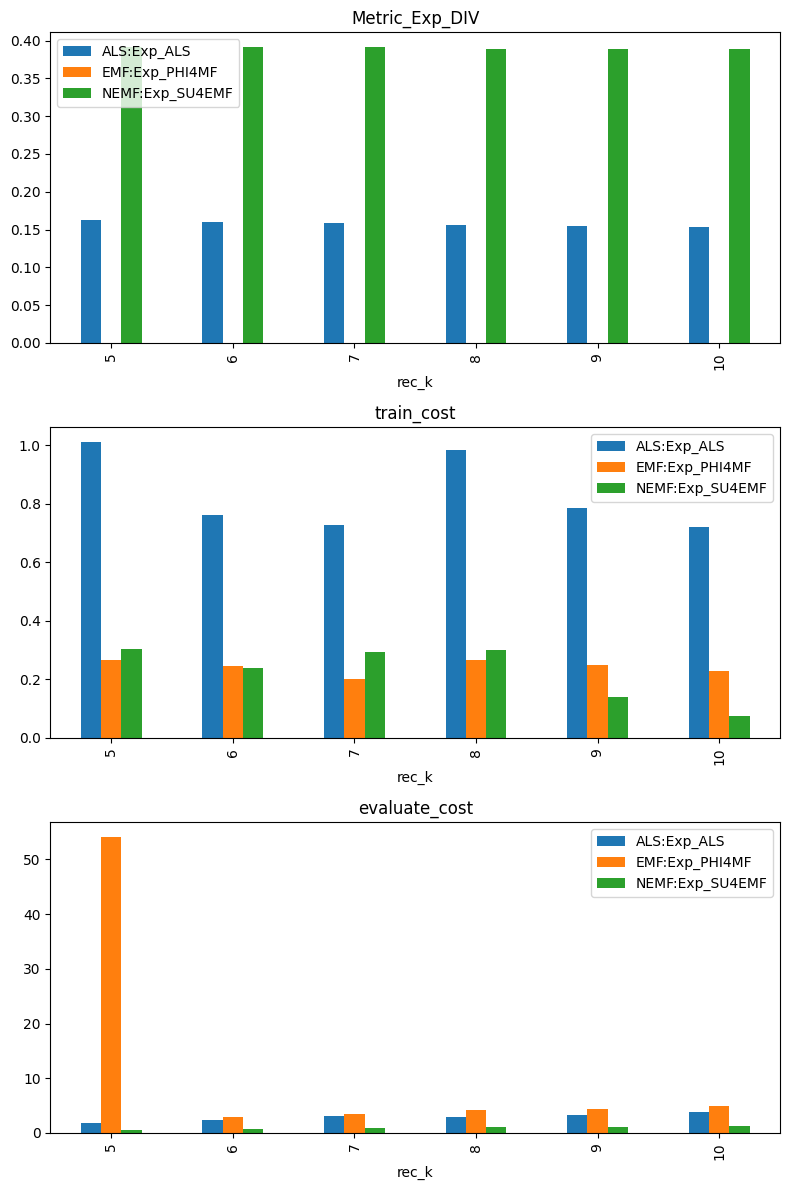

In [4]:
vis = Visualization()
vis.visualize_target_k(EE_list, target_k_name="rec_k", kind="bar")

### CASE 3 Visualize feature importance



In [3]:
import numpy as np
from cornac.models.fm_py import FMRec
from cornac.explainer.exp_limers import Exp_LIMERS
from cornac.datasets.goodreads import prepare_data
import warnings

warnings.filterwarnings("ignore")
from cornac.datasets import amazon_toy
import numpy as np
from cornac.data import FeatureModality
from cornac.eval_methods import RatioSplit


def create_item_features_from_aspects(at_sentiment):
    """Separate aspects and opinions from sentiment data and create item and user features from them."""
    items = {}
    users = {}
    for _, row in enumerate(at_sentiment):
        user, item, sentiments = row
        if user not in users:
            users[user] = []
        if item not in items:
            items[item] = []
        for sentiment in sentiments:
            if sentiment[0] not in items[item]:
                items[item].append(sentiment[0])  # aspect adds to item feature
            if sentiment[1] not in users[user]:
                users[user].append(sentiment[1])  # opinion adds to user feature

    item_aspect_pairs = np.array(
        [(item, feature) for item in items for feature in items[item]]
    )
    user_opinion_pairs = np.array(
        [(user, feature) for user in users for feature in users[user]]
    )
    return item_aspect_pairs, user_opinion_pairs, items.keys(), users.keys()


at_feedback = amazon_toy.load_feedback()
at_feedback = at_feedback[: len(at_feedback) // 20]  # reduce data size
at_sentiment = amazon_toy.load_sentiment()
items_feature, users_feature, items_list, users_list = (
    create_item_features_from_aspects(at_sentiment)
)
# remove unknown users and items from rating data
at_feedback_excl_unknowns = [
    x for x in at_feedback if x[0] in users_list and x[1] in items_list
]
rs = RatioSplit(
    data=at_feedback,
    test_size=0.2,
    item_feature=FeatureModality(items_feature),
    # user_feature=FeatureModality(users_feature), # user feature is not used in this experiment
    seed=42,
    exclude_unknowns=True,
)


fm = FMRec()
fm.fit(train_set=rs.train_set)

explainer = Exp_LIMERS(rec_model=fm, dataset=rs.train_set)
users = np.array(list(rs.train_set.uid_map.keys()))
items = np.array(list(rs.train_set.iid_map.keys()))
recommendations = fm.recommend_to_multiple_users(users, k=10)
explanations = explainer.explain_recommendations(recommendations, num_features=6)

Creating validation dataset of 0.01 of training for adaptive regularization
-- Epoch 1
Training MSE: 0.82993
-- Epoch 2
Training MSE: 0.55167
-- Epoch 3
Training MSE: 0.47564
-- Epoch 4
Training MSE: 0.43872
-- Epoch 5
Training MSE: 0.40678
-- Epoch 6
Training MSE: 0.38529
-- Epoch 7
Training MSE: 0.36703
-- Epoch 8
Training MSE: 0.35250
-- Epoch 9
Training MSE: 0.33837
-- Epoch 10
Training MSE: 0.32768


Computing explanations: 100%|██████████| 46680/46680 [19:01<00:00, 40.88it/s]


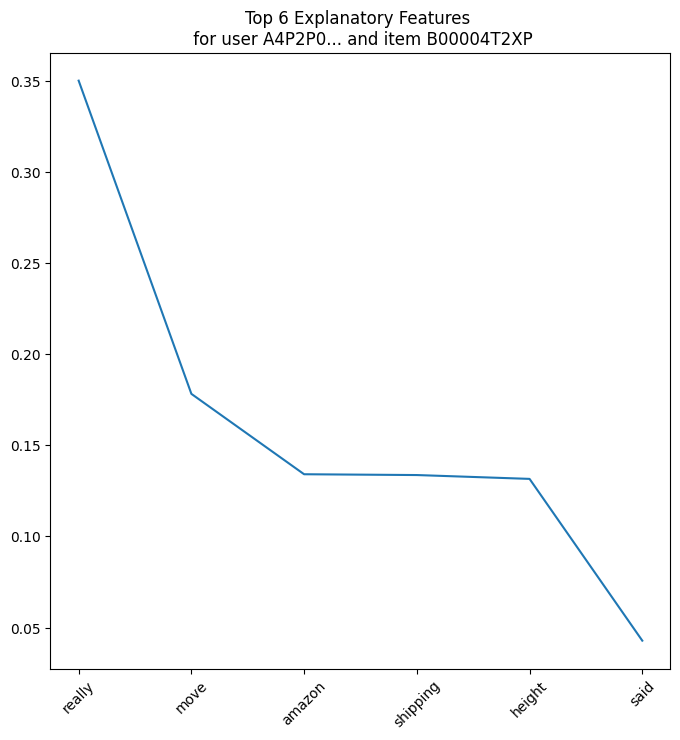

In [12]:
from cornac.experiment.visualization import Visualization

explanations_df = explanations.copy()
my_plots = Visualization()

# Create a plot for a specific user and item
ind_df = my_plots.create_individual_feature_importance_plot(
    explanations,
    user_id="A4P2P0GAMR7XX",
    item_id="B00004T2XP",
    type="line",
    top_k=6,
    save_plot=False,
)

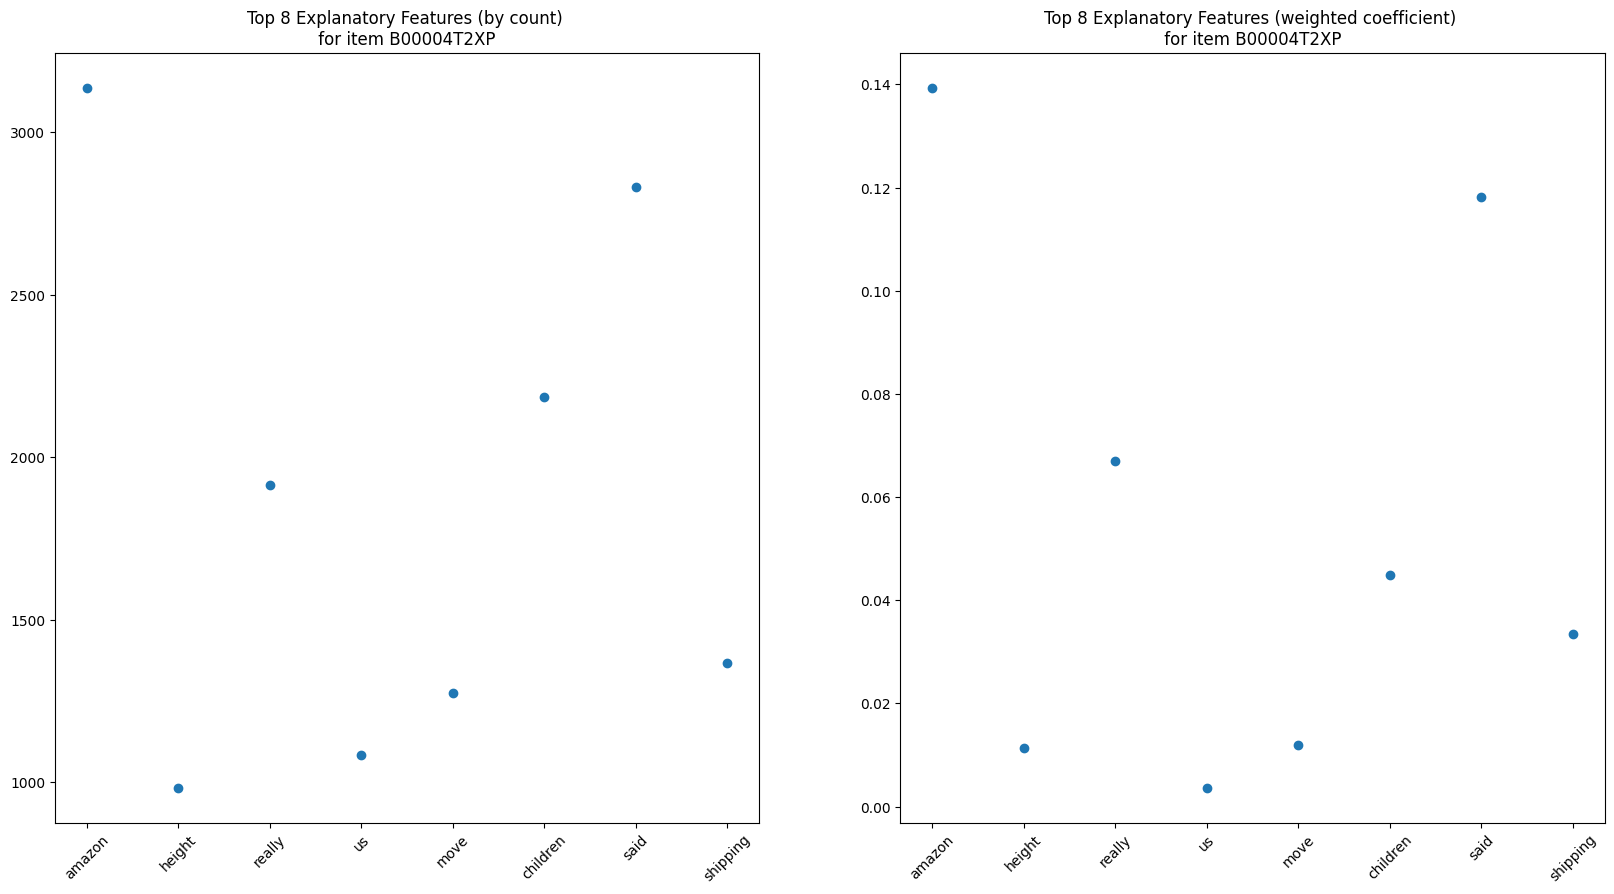

In [15]:
# Create a plot for a specific item
filtered_df1 = my_plots.create_aggregate_feature_importance_plot(
    explanations, item_id="B00004T2XP", type="scatter", top_k=8, save_plot=False
)

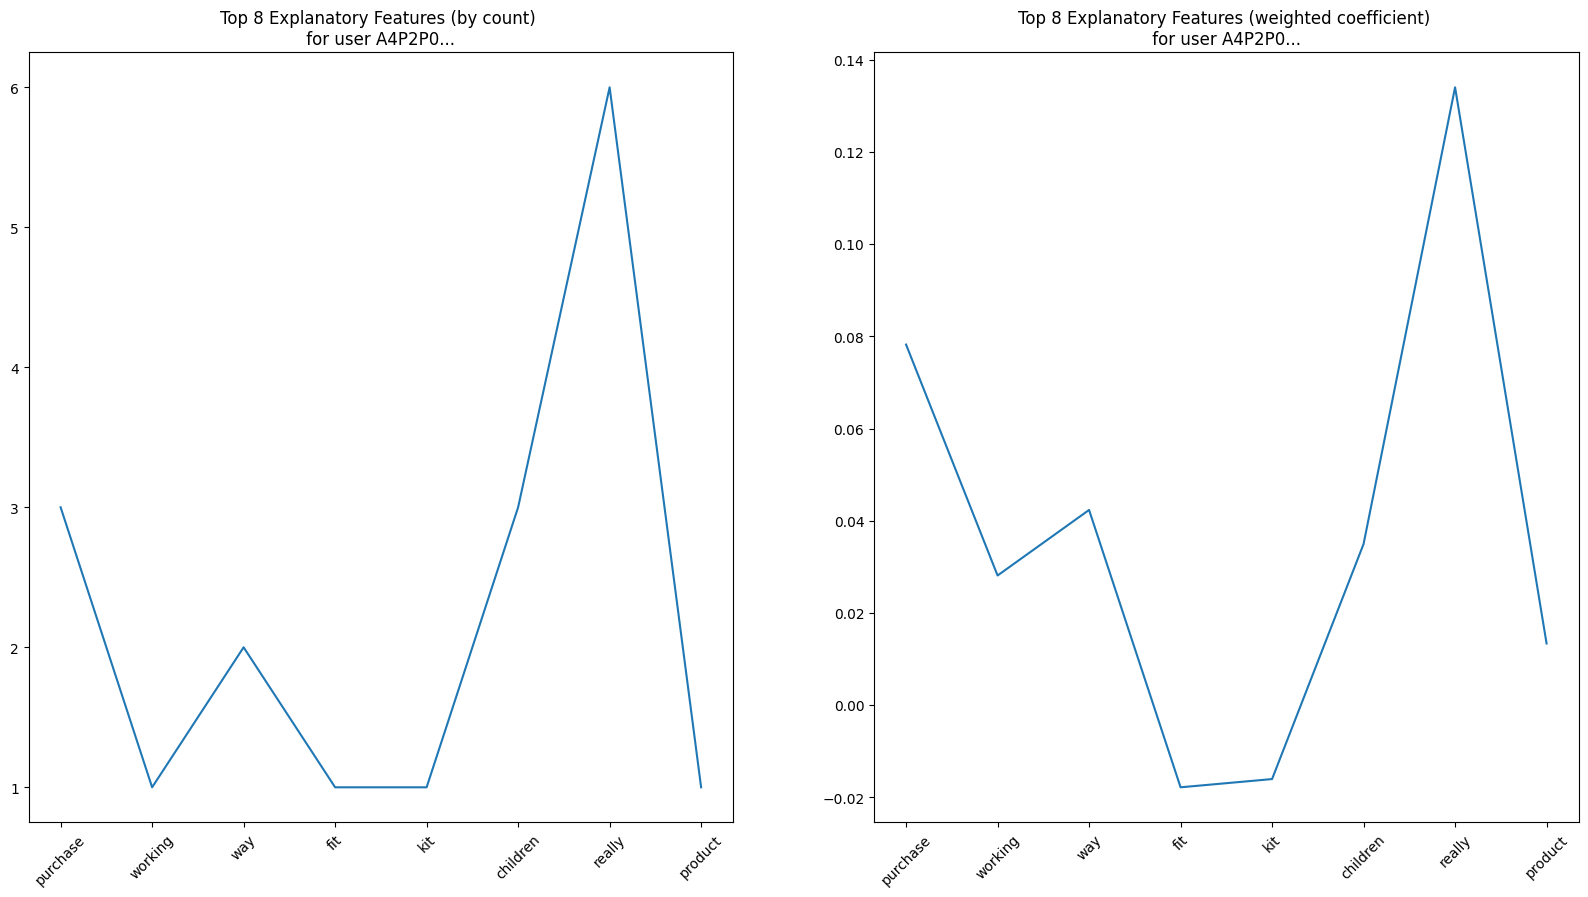

In [19]:
# Create a plot for a specific user
filtered_df2 = my_plots.create_aggregate_feature_importance_plot(
    explanations,
    user_id="A4P2P0GAMR7XX",
    type="line",
    top_k=8,
    save_plot=False,
)

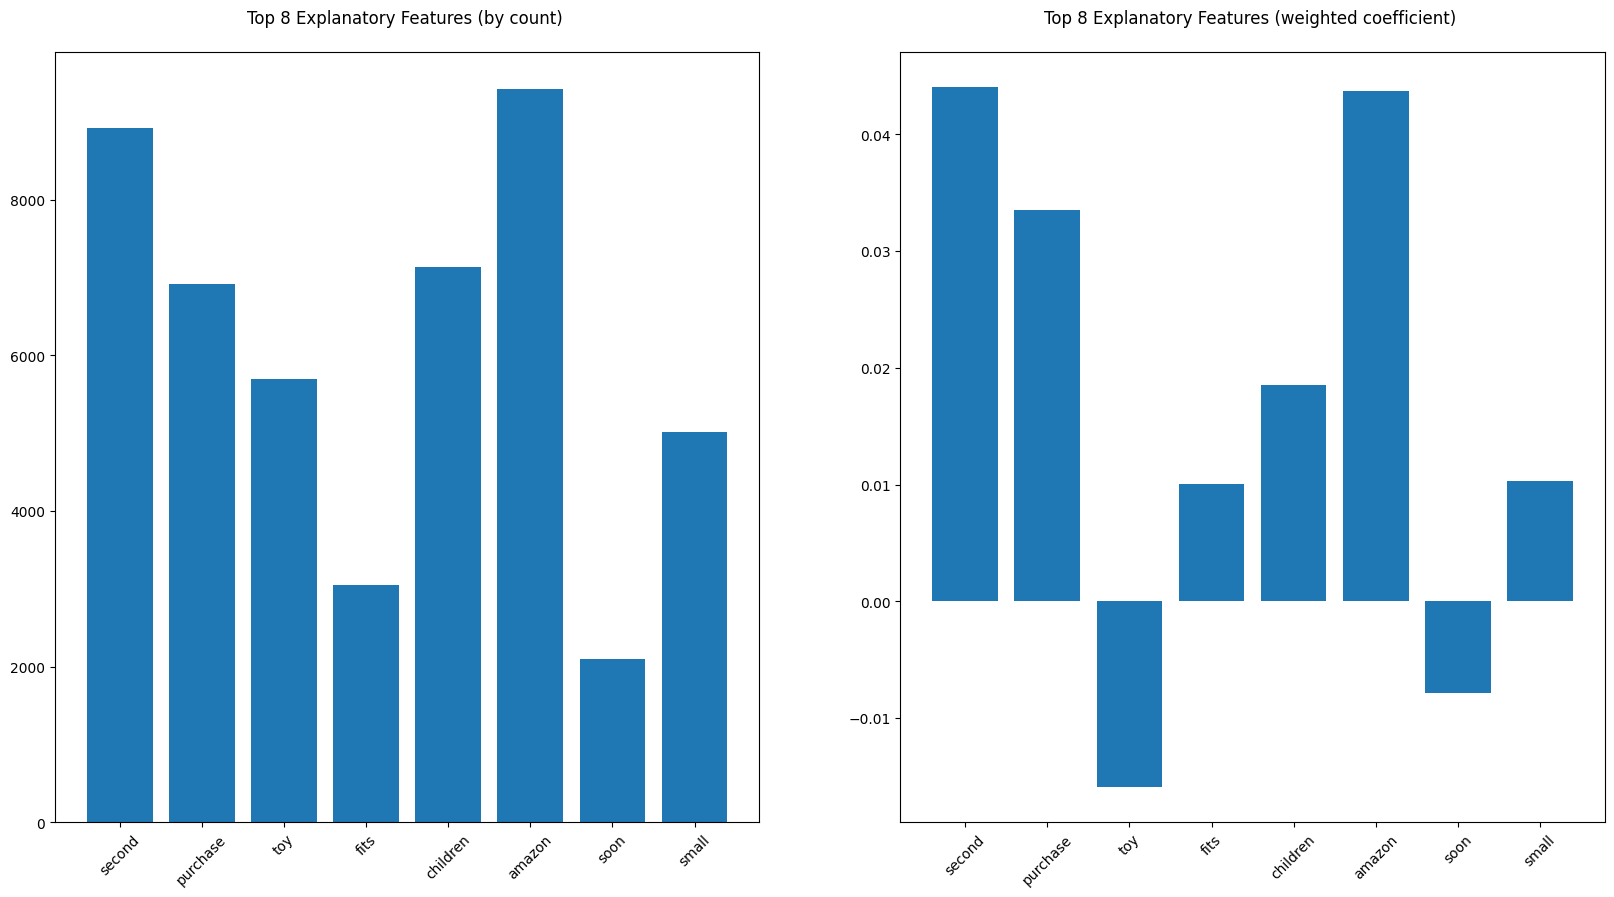

In [18]:
# Create a plot for all users
filtered_df3 = my_plots.create_aggregate_feature_importance_plot(
    explanations, type="bar", top_k=8, save_plot=False
)